<a href="https://colab.research.google.com/github/brkbyrktr/Medical_Cost_Analysis/blob/main/Medical_Cost_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
Akbank Machine Learning Bootcamp Project
Created by Burak Bayraktar
```



In [4]:
import pandas as pd  # Pandas kütüphanesi veri manipülasyonu için kullanılır.
import numpy as np  # NumPy kütüphanesi sayısal işlemler için kullanılır.
import seaborn as sns  # Seaborn kütüphanesi veri görselleştirmesi için kullanılır.
import matplotlib.pyplot as plt  # Matplotlib kütüphanesi grafik çizimi için kullanılır.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Makine öğrenimi modelini değerlendirmek ve ayarlamak için kullanılan araçlar.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler  # Veri ön işleme araçları.
from sklearn.linear_model import LinearRegression  # Doğrusal regresyon modeli.
from sklearn.tree import DecisionTreeRegressor  # Karar ağacı regresyon modeli.
from sklearn.ensemble import RandomForestRegressor  # Rastgele orman regresyon modeli.
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Hata metrikleri.


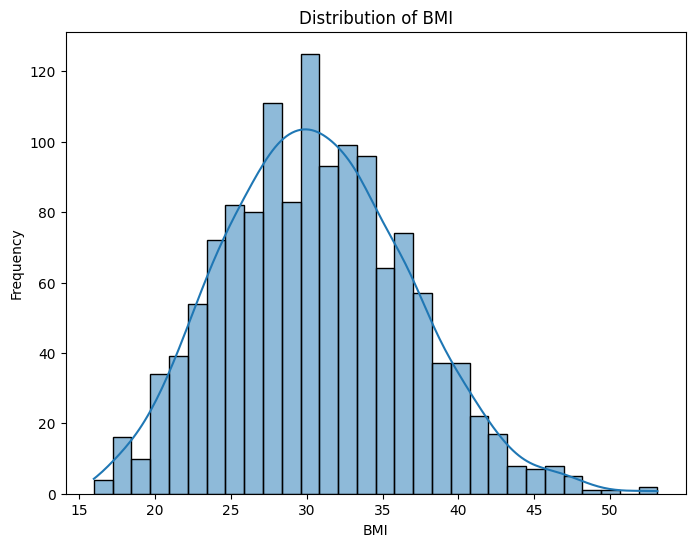

In [5]:
# Veri kümesini yükle
data = pd.read_csv("health_insurance_dataset.csv")

# BMI'nin dağılımını incele
plt.figure(figsize=(8, 6))  # Grafik boyutunu belirle
sns.histplot(data['bmi'], bins=30, kde=True)  # BMI değerlerinin histogramını çiz, 30 aralık kullan ve çekirdek yoğunluk tahmini ekle
plt.title("Distribution of BMI")  # Grafik başlığı
plt.xlabel("BMI")  # X ekseni etiketi
plt.ylabel("Frequency")  # Y ekseni etiketi
plt.show()  # Grafik göster


In [6]:
# Kategorik değişkenler için Etiket Kodlaması (Label Encoding) gerçekleştir
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])  # 'sex' sütununu etiket kodlama ile dönüştür
data['smoker'] = label_encoder.fit_transform(data['smoker'])  # 'smoker' sütununu etiket kodlama ile dönüştür

# 'region' değişkeni için One-Hot Encoding gerçekleştir
data = pd.get_dummies(data, columns=['region'], drop_first=True)  # 'region' sütununu tek değer kodlamasıyla dönüştür

# Veri kümesini özellikler (X) ve hedef (y) olarak ayır
X = data.drop('charges', axis=1)  # 'charges' sütununu çıkararak X özelliklerini belirle
y = data['charges']  # 'charges' sütunu hedef değişken olarak belirle

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Veriyi %80 eğitim, %20 test olarak ayır, rastgelelik için random_state kullan

# Veriyi Standart Ölçekleme kullanarak ölçeklendir
scaler = StandardScaler()  # Standart ölçekleme işlemi için bir ölçekleyici oluştur
X_train_scaled = scaler.fit_transform(X_train)  # Eğitim verisini ölçekle ve dönüştür
X_test_scaled = scaler.transform(X_test)  # Test verisini ölçekle


In [7]:
# Modelleri başlat ve eğit
models = {
    'Linear Regression': LinearRegression(),  # Doğrusal Regresyon modeli
    'Decision Tree': DecisionTreeRegressor(),  # Karar Ağacı Regresyon modeli
    'Random Forest': RandomForestRegressor()  # Rastgele Orman Regresyon modeli
}

results = {}  # Sonuçları depolamak için bir sözlük oluştur

for name, model in models.items():  # Her model için döngü
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')  # Haç doğrulama ile modelin performansını değerlendir
    results[name] = np.sqrt(-scores.mean())  # Ortalama negatif hata karesinin karekökünü alarak RMSE hesapla

# Model performanslarını yazdır
for name, score in results.items():  # Her model için performans sonucunu yazdır
    print(f'{name}: RMSE = {score}')  # Model adı ve RMSE değerini yazdır


Linear Regression: RMSE = 6160.185958948655
Decision Tree: RMSE = 6703.457436630413
Random Forest: RMSE = 5003.553149608414


In [8]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Rastgele Orman için ağaç sayıları
    'max_depth': [None, 10, 20, 30],  # Ağaçların maksimum derinlikleri
    'min_samples_split': [2, 5, 10],  # Bir düğümü bölmek için gereken minimum örnek sayısı
    'min_samples_leaf': [1, 2, 4]  # Bir yaprak düğümünde olması gereken minimum örnek sayısı
}

rf_model = RandomForestRegressor(random_state=42)  # Rastgele Orman Regresyon modelini başlat
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')  # Parametre aralığını taramak için en iyi parametreleri bul
grid_search.fit(X_train_scaled, y_train)  # Eğitim verisine uygun parametreleri bul

best_rf_model = grid_search.best_estimator_  # En iyi performans gösteren modeli seç


In [9]:
y_pred = best_rf_model.predict(X_test_scaled)  # En iyi hiperparametrelerle eğitilen modeli kullanarak test verileri üzerinde tahmin yap

mse = mean_squared_error(y_test, y_pred)  # Gerçek değerlerle tahmin değerleri arasındaki ortalama karesel hata
mae = mean_absolute_error(y_test, y_pred)  # Gerçek değerlerle tahmin değerleri arasındaki ortalama mutlak hata

print(f'Mean Squared Error: {mse}')  # Ortalama Karesel Hata'yı yazdır
print(f'Mean Absolute Error: {mae}')  # Ortalama Mutlak Hata'yı yazdır


Mean Squared Error: 19011410.546196193
Mean Absolute Error: 2478.7782954193353
